In [7]:
#importing necessary libraries

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from numpy import concatenate
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf



In [16]:
#reading the csv file into pandas data frame
data = pd.read_csv("/work/DSCI400-Project/src/cached_data/norm_ALL_DB_COL_data_100_threshold.csv")

data = data.drop(['True'], axis=1)

transpose_data = data.transpose()

transpose_data.index

print(data.iloc[100])

1980    0.000000
1981    0.063647
1982    0.039685
1983    0.131303
1984    0.092702
1985    0.014044
1986    0.135963
1987    0.124757
1988    0.104302
1989    0.023859
1990    0.095325
1991    0.172014
1992    0.407806
1993    0.367039
1994    0.259455
1995    0.289488
1996    0.325371
1997    0.867276
1998    0.995857
1999    0.655711
2000    0.882172
2001    0.942498
2002    0.785003
2003    0.696144
2004    0.782979
2005    0.873855
2006    0.815233
2007    0.736009
2008    0.787733
2009    1.000000
2010    0.967738
Name: 100, dtype: float64


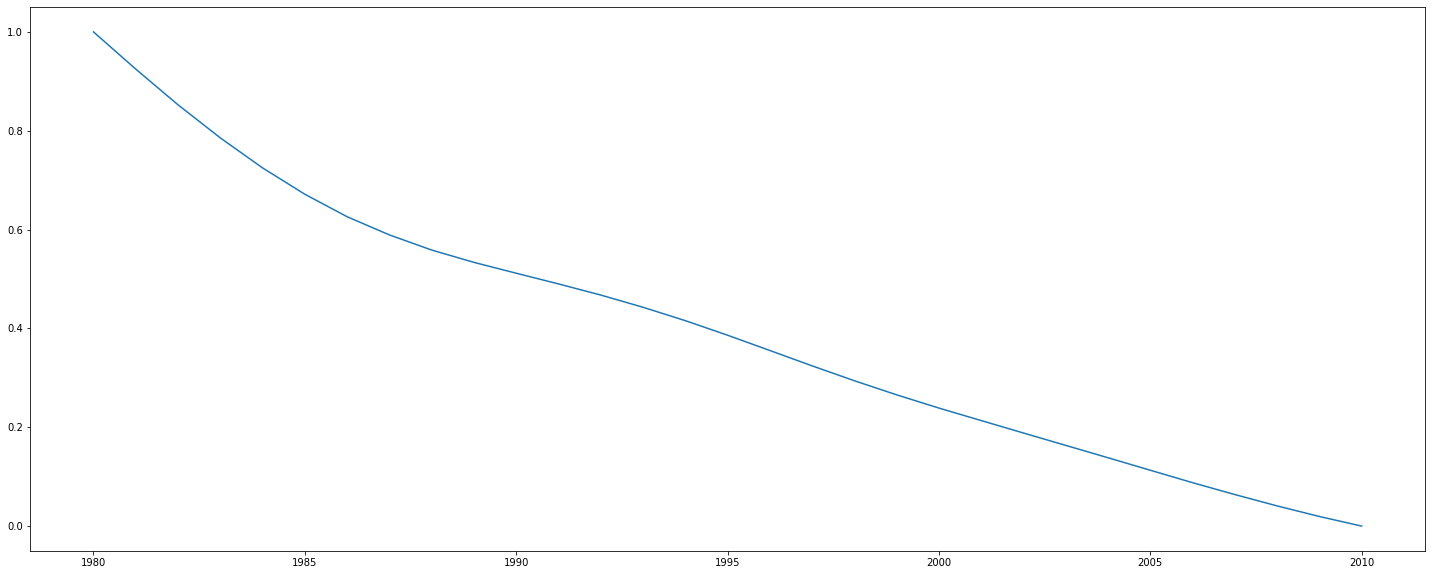

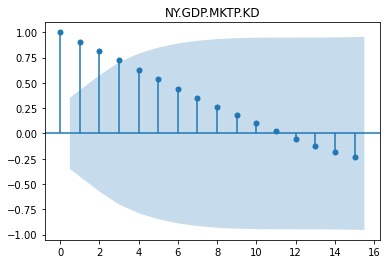

[[1.00000000e+00 9.31263946e-01 8.64599936e-01 ... 4.45489321e-02
  2.11189034e-02 0.00000000e+00]
 [1.59747111e-02 1.26919673e-02 5.26825947e-03 ... 8.53440958e-01
  9.15356693e-01 1.00000000e+00]
 [1.00000000e+00 9.24761135e-01 8.52457543e-01 ... 4.08242729e-02
  1.94387037e-02 0.00000000e+00]
 ...
 [0.00000000e+00 2.98611709e-04 7.03508941e-04 ... 8.99939772e-01
  9.85271863e-01 1.00000000e+00]
 [0.00000000e+00 1.57350932e-02 3.13781312e-02 ... 8.86167054e-01
  9.40573838e-01 1.00000000e+00]
 [5.60800009e-02 5.70134594e-03 0.00000000e+00 ... 9.68640155e-01
  9.70004910e-01 1.00000000e+00]]
(1420, 30) (1420,) (356, 30) (356,)
(1420, 1, 30) (1420,) (356, 1, 30) (356,)
Epoch 1/10
20/20 - 2s - loss: 0.3770 - val_loss: 0.2083
Epoch 2/10
20/20 - 0s - loss: 0.2021 - val_loss: 0.1701
Epoch 3/10
20/20 - 0s - loss: 0.1574 - val_loss: 0.1391
Epoch 4/10
20/20 - 0s - loss: 0.1312 - val_loss: 0.1219
Epoch 5/10
20/20 - 0s - loss: 0.1193 - val_loss: 0.1177
Epoch 6/10
20/20 - 0s - loss: 0.1140 - val

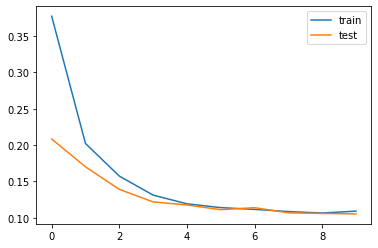

(1420,)
Test RMSE: 0.160
Test RMSE: 0.162


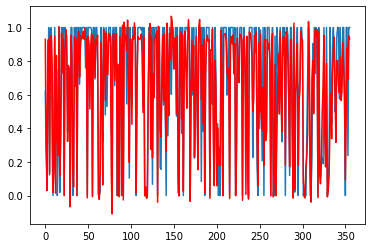

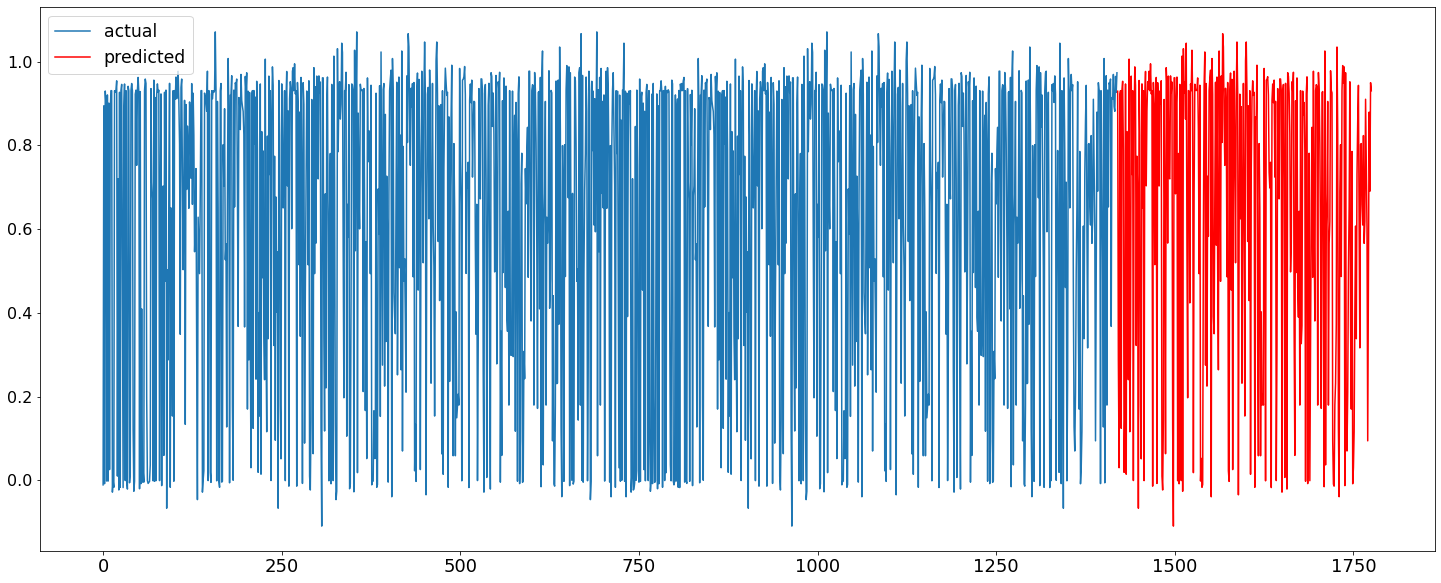

In [22]:
#setting the Date column as the index of the data frame
'''
data['Date'] = data['Date'].apply(pd.to_datetime)
data.set_index('Date',inplace=True)

#selecting only those rows, which has City as 'Delhi'
df = data.loc[data['City']=='Delhi']
'''
df = data
df.describe()

#We will use it further to show the graph of multi step prediction
df_train = df.iloc[0:1420]
df_test = df.iloc[1420:]

#plotting the line graph of whatever 2nd indicator is
df.iloc[2].plot(figsize=(25,10))

plot_acf(df.iloc[104])
plt.title('NY.GDP.MKTP.KD')

plt.show()

#scale the values
dataset = data.values
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

#divide the data into train and test data
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(train)

#index the data into dependent and independent variables
train_X, train_y = train[:, :30], train[:, 30]
test_X, test_y = test[:, :30], test[:, 30]
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

#convert data into suitable dimension for using it as input in LSTM network
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

model = Sequential()
model.add(LSTM(250, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

history = model.fit(train_X, train_y, epochs=10, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

#prediction on training and testing data
train_predict = model.predict(train_X)    
test_predict = model.predict(test_X)       

#converting from three dimension to two dimension
train_X = train_X.reshape((train_X.shape[0], train_X.shape[2]))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

inv_train_predict = concatenate((train_predict, train_X), axis=1)
inv_test_predict = concatenate((test_predict, test_X), axis=1)

#transforming to original scale
inv_train_predict = scaler.inverse_transform(inv_train_predict)
inv_test_predict = scaler.inverse_transform(inv_test_predict)

#predicted values on training data
inv_train_predict = inv_train_predict[:,0]
inv_train_predict

#predicted values on testing data
inv_test_predict = inv_test_predict[:,0]
inv_test_predict

#scaling back the original train labels
train_y = train_y.reshape((len(train_y), 1))
inv_train_y = concatenate((train_y, train_X), axis=1)
inv_train_y = scaler.inverse_transform(inv_train_y)
inv_train_y = inv_train_y[:,0]
print(inv_train_y.shape)
#scaling back the original test labels
test_y = test_y.reshape((len(test_y), 1))
inv_test_y = concatenate((test_y, test_X), axis=1)
inv_test_y = scaler.inverse_transform(inv_test_y)
inv_test_y = inv_test_y[:,0]

#calculating rmse on train data
rmse_train = sqrt(mean_squared_error(inv_train_y, inv_train_predict))
print('Test RMSE: %.3f' % rmse_train)

#calculating rmse on test data
rmse_test = sqrt(mean_squared_error(inv_test_y, inv_test_predict))
print('Test RMSE: %.3f' % rmse_test)

#plotting the graph of test actual vs predicted
inv_test_y = inv_test_y.reshape(-1,1)
inv_test_y.shape

t = np.arange(0,356,1)

plt.plot(t,inv_test_y,label="actual")
plt.plot(t,inv_test_predict,'r',label="predicted")
plt.show()

#plotting the graph to show multi step prediction
plt.figure(figsize=(25, 10))
plt.plot(df_train.index, inv_train_predict,label="actual")
plt.plot(df_test.index, inv_test_predict, color='r',label="predicted")
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()

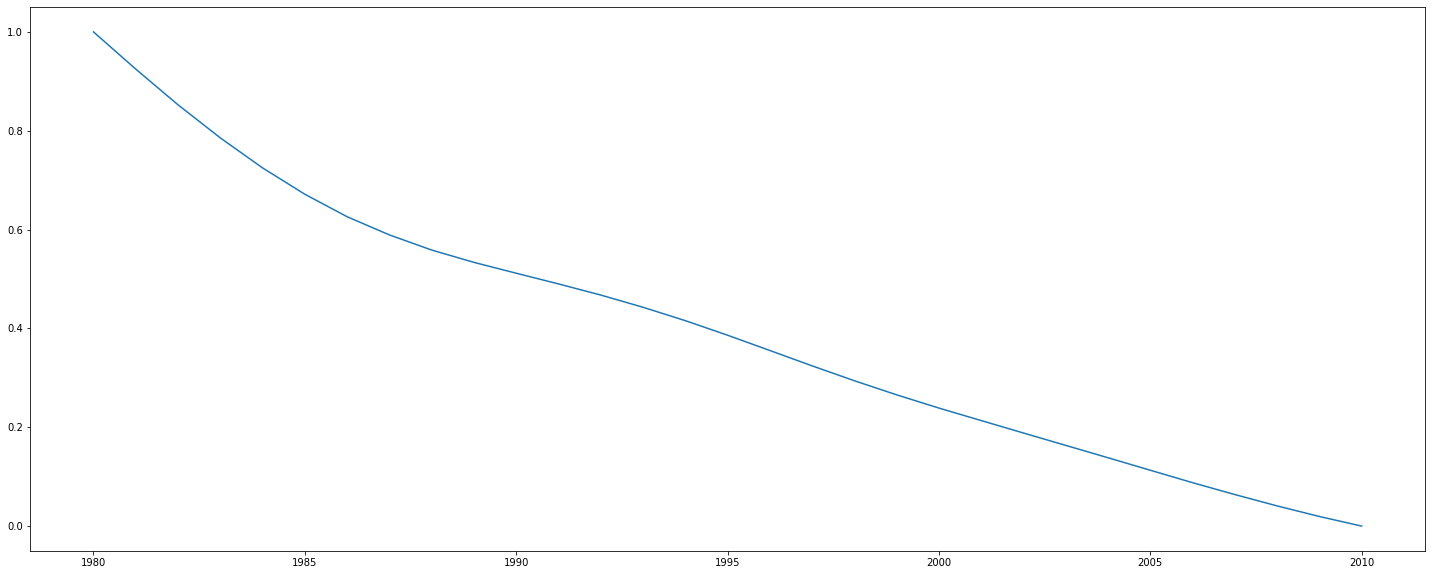

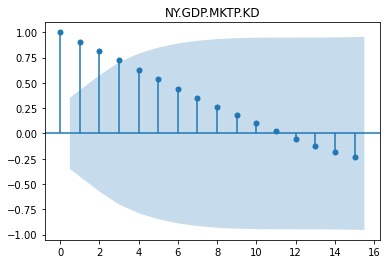

(1776, 31)
(1420, 31)
(356, 31)


In [19]:
df = data
df.describe()

#We will use it further to show the graph of multi step prediction
df_train = df.iloc[0:1776]
df_test = df.iloc[1776:]

#plotting the line graph of whatever 2nd indicator is
df.iloc[2].plot(figsize=(25,10))

plot_acf(df.iloc[104])
plt.title('NY.GDP.MKTP.KD')

plt.show()

#scale the values
dataset = data.values
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
print(dataset.shape)
#divide the data into train and test data
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(train.shape)
print(test.shape)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=72b1e015-02d7-48b2-beb6-dcae4caaa79e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>